In [1]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import sys
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.metrics import confusion_matrix,accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import euclidean_distances, cosine_similarity
from sklearn.utils import shuffle
from sklearn.utils import class_weight
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
import tensorflow as tf
import tensorflow.python.keras
from tensorflow.python.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation, BatchNormalization,SpatialDropout1D,Bidirectional, Embedding, LSTM
from tensorflow.python.keras import backend as K
from tensorflow.keras.utils import to_categorical
from tensorflow.python.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer, text_to_word_sequence
import re

np.set_printoptions(threshold=sys.maxsize)

pd.set_option('display.max_rows',1000)
pd.set_option('display.max_columns',1000)

# GPU support
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print(physical_devices)
tf.config.experimental.set_memory_growth(physical_devices[0], True)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
labels = ["business", "entertainment", "politics", "sport", "tech"]
targets = [0,1,2,3,4]
dataset = []
for root, dirs, files in os.walk("./archive/bbc", topdown=False):
    class_type = root.split("\\")
    print(class_type)
    if len(class_type)> 1:
        for file in files: 
            with open(root+"/"+file) as f: 
                text = f.read()
                dataset.append([class_type[1], text])  

['./archive/bbc', 'business']
['./archive/bbc', 'entertainment']
['./archive/bbc', 'politics']
['./archive/bbc', 'sport']
['./archive/bbc', 'tech']
['./archive/bbc']


In [3]:
print(len(dataset))

2225


In [4]:
import pickle

with open('./archive/bbc/dataset.list', "wb") as f: 
    pickle.dump(dataset, f)

In [4]:
import pickle

with open('./archive/bbc/dataset.list', "rb") as f: 
    dataset = pickle.load(f)

print(len(dataset))

2225


In [5]:
dataset = pd.DataFrame(list(dataset), columns=["labels", "text"])

<AxesSubplot:xlabel='labels', ylabel='count'>

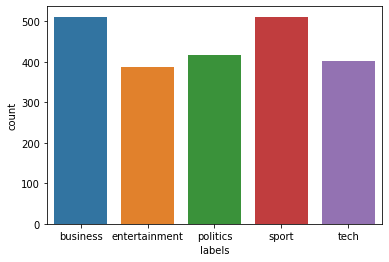

In [6]:
sns.countplot(x="labels", data=dataset)

In [7]:
dataset["labels"] = dataset["labels"].replace({"business":0, "entertainment":1, "politics":2, "sport":3, "tech":4})

In [8]:
X = dataset["text"].values
y = dataset["labels"].values

y = to_categorical(y)

In [9]:
tokenizer = Tokenizer(num_words= None)
tokenizer.fit_on_texts(X)
sequences = tokenizer.texts_to_sequences(X)

# # Example
# print(X[0])
# print(sequences[0])

In [10]:
X_encoded = pad_sequences(sequences, maxlen=120, padding='post')

print(X_encoded[0])

[ 1471     4  2210  1049  4685  8262     8     2  6615    40  1165    17
   151     3  1412     2  4090    32  1413    70  3300    21    48   117
  3301    12    18   191   959     2   349  6241     2  2609   881     6
     5   216     9     8   159  1391    21     1  2528     1   137    11
    12    13  2390     2  3129     1   911    12   510     2   109  2852
     7   357  2853    34    12  1015   109    20  4887    12  4366     2
  9962     1   114    12  1165     7     5   216    16   786    99  4888
 20599  2669     3     5  1266     6  3300   264    34    12    35   613
    17  2177  1471    12    22    67   640     1   444     3    40  1266
     6  3300   264    17     5  1197    10     1   792     3     9  1266]


In [11]:
# Split into training set and test set. Use a test size = 3000 and a random state = 0
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.10, random_state=0,stratify = y)

In [12]:
# Design a LSTM neural network and use an embedding layer.
vocabulary_size = X_train.max()

model = Sequential()

model.add(Embedding(vocabulary_size+1, 150, input_length=120))
model.add(SpatialDropout1D(0.3))
# model.add(LSTM(500,return_sequences=True, dropout=0.2, recurrent_dropout=0.15))
model.add(LSTM(100, dropout=0.10, recurrent_dropout=0.1))
model.add(Dense(500, activation='relu'))
# model.add(Dense(50, activation='relu'))
model.add(Dense(5, activation='sigmoid'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])



In [13]:
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
import time
from datetime import datetime, date
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, min_delta=0.001, patience=5, restore_best_weights=True)

END = f'{datetime.timestamp(datetime.now())}_{date.today().strftime("%b-%d-%Y")}'

NAME = 'logs/bbc/bbc_classification_log_{}'.format(int(time.time()))
tensorboard = TensorBoard(log_dir=f'{NAME}_{END}')

checkpoint_filepath = f'models/bbc/bbc_classification_{END}.h5'
checkpointer = ModelCheckpoint(filepath=checkpoint_filepath,save_weights_only=True,monitor='val_accuracy',mode='max',save_best_only=True)

callback_list = [tensorboard, checkpointer, es]

In [14]:
history = model.fit(X_train, y_train, epochs=100,verbose=1,batch_size=128, validation_split=0.2, callbacks=callback_list)

Epoch 1/100
13/13 [==============================] - 28s 2s/step - loss: 1.6056 - accuracy: 0.2411 - val_loss: 1.5932 - val_accuracy: 0.3766
Epoch 2/100
13/13 [==============================] - 22s 2s/step - loss: 1.4667 - accuracy: 0.4129 - val_loss: 1.2313 - val_accuracy: 0.4589
Epoch 3/100
13/13 [==============================] - 22s 2s/step - loss: 1.0804 - accuracy: 0.4760 - val_loss: 0.9804 - val_accuracy: 0.5212
Epoch 4/100
13/13 [==============================] - 22s 2s/step - loss: 0.7508 - accuracy: 0.6465 - val_loss: 0.7572 - val_accuracy: 0.6833
Epoch 5/100
13/13 [==============================] - 22s 2s/step - loss: 0.6300 - accuracy: 0.8457 - val_loss: 0.8225 - val_accuracy: 0.7232
Epoch 6/100
13/13 [==============================] - 22s 2s/step - loss: 0.3698 - accuracy: 0.9288 - val_loss: 0.7911 - val_accuracy: 0.7830
Epoch 7/100
13/13 [==============================] - 29s 2s/step - loss: 0.2340 - accuracy: 0.9656 - val_loss: 0.6476 - val_accuracy: 0.8204
Epoch 8/100
1

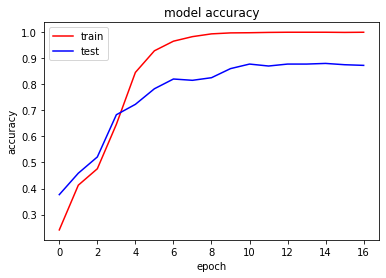

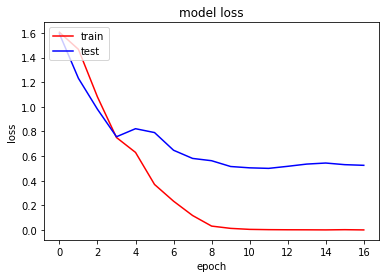

In [15]:
# Plot history

# Accuray 
plt.plot(history.history['accuracy'],'r')
plt.plot(history.history['val_accuracy'],'b')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# Loss 
plt.plot(history.history['loss'],'r')
plt.plot(history.history['val_loss'],'b')

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [16]:
# Validate model on training set
rounded_labels=np.argmax(y_test, axis=1)

y_pred = np.argmax(model.predict(X_test),axis=-1)

print(classification_report(rounded_labels, y_pred))

cf = confusion_matrix(rounded_labels, y_pred)

print(cf)
print(accuracy_score(rounded_labels, y_pred) * 100) 

              precision    recall  f1-score   support

           0       0.93      0.78      0.85        51
           1       0.81      0.87      0.84        39
           2       0.77      0.81      0.79        42
           3       1.00      0.96      0.98        51
           4       0.78      0.88      0.82        40

    accuracy                           0.86       223
   macro avg       0.86      0.86      0.86       223
weighted avg       0.87      0.86      0.86       223

[[40  1  6  0  4]
 [ 0 34  2  0  3]
 [ 2  3 34  0  3]
 [ 0  2  0 49  0]
 [ 1  2  2  0 35]]
86.09865470852019
